In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from functions.epsilon_greedy_agent import get_action_epsilon_greedy
from functions.rewards import get_reward

In [8]:
def ar1_channel_power(P_avg_dB, sigma2_P_dB, tc, fs, D):
    n_tc = tc*fs
    phi = np.exp(-np.log(2)/n_tc)
    var_e = sigma2_P_dB*(1 - phi**2)
    
    C_NWARM = 50
    N = np.ceil(D*fs).astype(int)

    Y = np.zeros(C_NWARM + N)
    e = np.sqrt(var_e)*np.random.randn(C_NWARM + N)

    for k in range(1, C_NWARM + N):
        Y[k] = phi*Y[k-1] + e[k]

    P_dB = P_avg_dB + Y[C_NWARM + 1:]

    return P_dB

In [155]:
P_avg_dB = 7
sigma2_P_dB = 1
tc = 200
fs = 1/30
D = 12000

P_dB = ar1_channel_power(P_avg_dB, sigma2_P_dB, tc, fs, D)

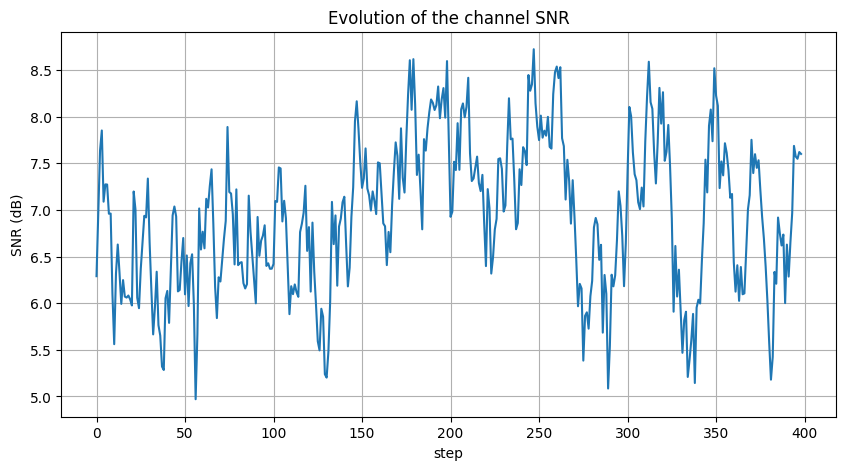

In [156]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(P_dB)
ax.set_xlabel('step')
ax.set_ylabel('SNR (dB)')
ax.set_title('Evolution of the channel SNR')
ax.grid(True)
plt.show()

In [24]:
def supposed(x , alpha, offset, factor, up):
    return factor*(((np.exp(-alpha*(x-offset)) - np.exp(alpha*(x-offset)))/(np.exp(-alpha*(x-offset)) + np.exp(alpha*(x-offset)))) + up)

def anal_estimation(supposed_general_form, x_data, y_data):
    popt, _ = curve_fit(supposed_general_form, x_data, y_data,bounds=([0,-20,0,0],[2,20,1,5]), maxfev=5000)
    alpha, offset, factor, up = popt
    
    def estimation(X):
        return supposed(X, alpha, offset, factor, up)
    
    return estimation

In [26]:
df = pd.read_csv('data/TEP_vs_SNR.csv')
columns = df.columns.values
columns = np.delete(columns, 0)
x_data = [float(x) for x in columns]

f_DSSS1 = anal_estimation(supposed, x_data, np.array(df[df['SNR']=='TEP_DSSS1'][columns]).reshape(-1))
f_DSSS3 = anal_estimation(supposed, x_data, np.array(df[df['SNR']=='TEP_DSSS3'][columns]).reshape(-1))
f_DSSS7 = anal_estimation(supposed, x_data, np.array(df[df['SNR']=='TEP_DSSS7'][columns]).reshape(-1))
f_DSSS15 = anal_estimation(supposed, x_data, np.array(df[df['SNR']=='TEP_DSSS15'][columns]).reshape(-1))

bitrates = np.array([2520, 840, 360, 168])

In [157]:
def train(n_iter, n_agents, alpha, eps, bitrates):
    k = bitrates.size
    action_values = np.zeros((n_iter, n_agents, k))
    action_counts = np.zeros((n_iter, n_agents, k))
    rewards = np.zeros((n_iter, n_agents))
    actions_chosen = np.zeros((n_iter, n_agents, k))

    for t in range(n_iter):
        snr = P_dB[t] # Current SNR
        per_values = np.array([f_DSSS1(snr), f_DSSS3(snr), f_DSSS7(snr), f_DSSS15(snr)])
        for agent in range(n_agents):
            action = get_action_epsilon_greedy(action_values[t, agent, :], eps)
            reward = get_reward(per_values, bitrates, action)
            action_counts[t + 1:, agent, action] = action_counts[t, agent, action] + 1
            action_values[t + 1:, agent, action] = action_values[t, agent, action] + alpha*(reward - action_values[t, agent, action])
            actions_chosen[t, agent, action] = 1
            rewards[t, agent] = reward
    return action_values, rewards, actions_chosen

### Experiment 1: Mean reward for different values of $\alpha$

In [158]:
n_iter = P_dB.size
eps = 0.05
n_agents = 1000

alpha = [1e-3, 1e-2, 0.1]
_, rewards1, _ = train(n_iter, n_agents, alpha[0], eps, bitrates)
_, rewards2, _ = train(n_iter, n_agents, alpha[1], eps, bitrates)
_, rewards3, _ = train(n_iter, n_agents, alpha[2], eps, bitrates)

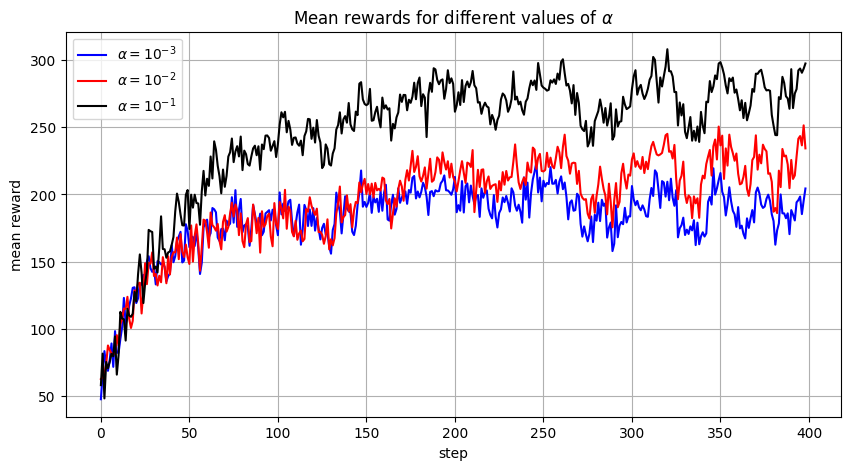

In [159]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(rewards1, axis=1), color='b', label=r'$\alpha=10^{-3}$')
ax.plot(np.mean(rewards2, axis=1), color='r', label=r'$\alpha=10^{-2}$')
ax.plot(np.mean(rewards3, axis=1), color='k', label=r'$\alpha=10^{-1}$')
ax.grid(True)
ax.set_xlabel('step')
ax.set_ylabel('mean reward')
ax.set_title(r'Mean rewards for different values of $\alpha$')
ax.legend()
plt.show()

### Experiment 2: Influence of $\varepsilon$ on the total reward

In [108]:
eps_values = np.linspace(0, 1, num=100)
alpha = 1e-3
total_rewards = list()

for eps in eps_values:
    _, rewards, _ = train(n_iter, n_agents, alpha, eps, bitrates)
    total_rewards.append(np.mean(rewards[-1, :]))

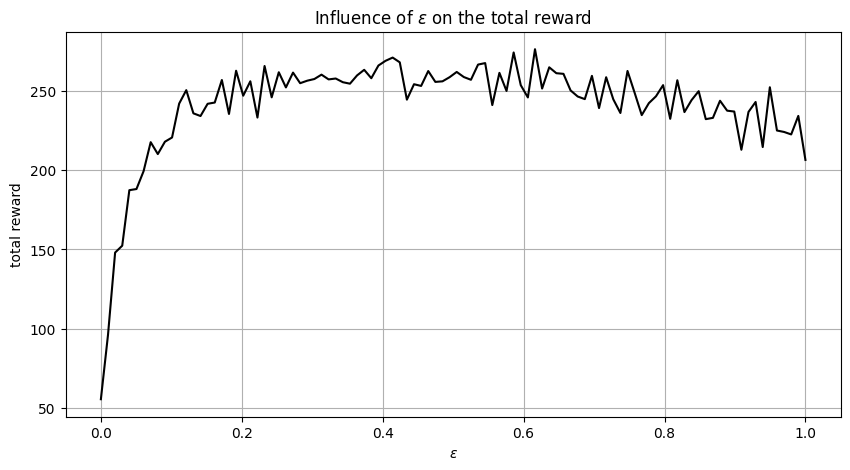

In [109]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eps_values, total_rewards, color='k')
ax.grid(True)
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel('total reward')
ax.set_title(r'Influence of $\varepsilon$ on the total reward')
plt.show()

### Experiment 3: Ratios of the chosen modulation methods

In [160]:
alpha = 1e-3
eps = 1e-3
_, _, actions_chosen = train(n_iter, n_agents, alpha, eps, bitrates)

In [161]:
ratio_DSSS1 = np.mean(actions_chosen[:,:,0], axis=1)
ratio_DSSS3 = np.mean(actions_chosen[:,:,1], axis=1)
ratio_DSSS7 = np.mean(actions_chosen[:,:,2], axis=1)
ratio_DSSS15 = np.mean(actions_chosen[:,:,3], axis=1)

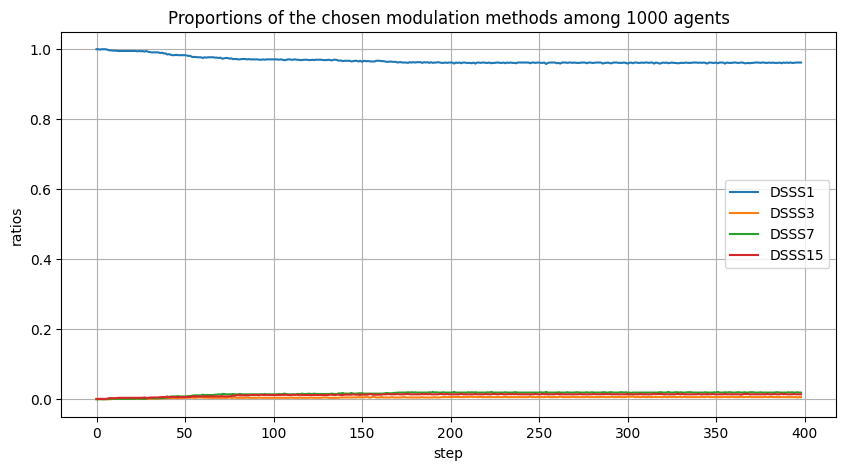

In [164]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ratio_DSSS1, label='DSSS1')
ax.plot(ratio_DSSS3, label='DSSS3')
ax.plot(ratio_DSSS7, label='DSSS7')
ax.plot(ratio_DSSS15, label='DSSS15')
ax.grid(True)
ax.legend()
ax.set_xlabel('step')
ax.set_ylabel('ratios')
ax.set_title(f'Proportions of the chosen modulation methods among {n_agents} agents')
plt.show()